In [2]:
from pathlib import Path

root = Path("/mnt/cephfs-mount/chenchen/mmflood")
count = 0

for event_dir in root.iterdir():
    if not event_dir.is_dir():
        continue
    
    s1_dir = event_dir / "s1_raw"
    if not s1_dir.exists():
        continue

    count += len(list(s1_dir.glob("*.tif")))

print( count)


1748


In [3]:
import rasterio
from pathlib import Path

tif_path = "/mnt/cephfs-mount/chenchen/mmflood/EMSR107-1/s1_raw/EMSR107-1-1.tif"

with rasterio.open(tif_path) as src:
    print("CRS       :", src.crs)
    print("Transform :", src.transform)
    print("Bounds    :", src.bounds)


CRS       : EPSG:4326
Transform : | 0.00, 0.00, 14.42|
| 0.00,-0.00, 45.73|
| 0.00, 0.00, 1.00|
Bounds    : BoundingBox(left=14.416132430999959, bottom=45.68617928533084, right=14.508332749000001, top=45.733552474999975)


        id        lat        lon
0  EMSR446   0.629765  30.782864
1  EMSR437  43.804044  -0.714876
2  EMSR314   7.071977   6.646897
3  EMSR456  14.086087 -83.482759
4  EMSR479  17.932890 -92.916162 95


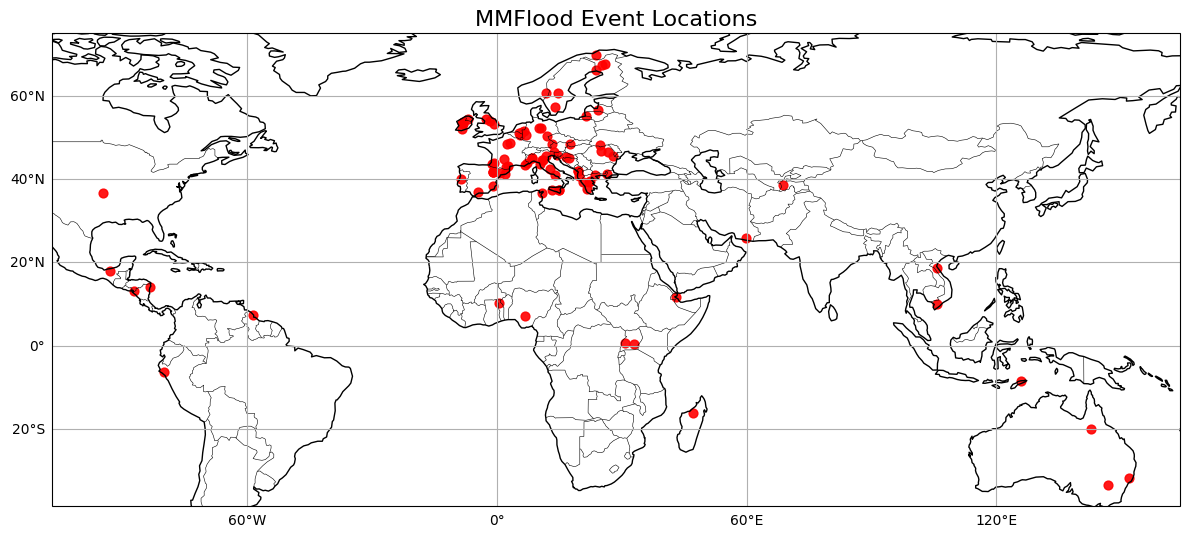

In [10]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

with open("/mnt/cephfs-mount/chenchen/mmflood/activations.json", "r") as f:
    data = json.load(f)

# 2. 转为 DataFrame
rows = []
for k, v in data.items():
    rows.append({
        "id": k,
        "lat": v["lat"],
        "lon": v["lon"],
    })

df = pd.DataFrame(rows)

print(df.head(), len(df))



fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_title("MMFlood Event Locations", fontsize=16)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.4)


gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False


ax.scatter(
    df["lon"],
    df["lat"],
    s=40,
    color="red",  
    alpha=0.9,
    transform=ccrs.PlateCarree(),
)

plt.tight_layout()
plt.show()


        id                                       title    country        lat  \
0  EMSR446                             Flood in Uganda     Uganda   0.629765   
1  EMSR437               Flood in South West of France     France  43.804044   
2  EMSR314                           Floods in Nigeria    Nigeria   7.071977   
3  EMSR456  Flood in North Caribbean Region, Nicaragua  Nicaragua  14.086087   
4  EMSR479                    Flood in Tabasco, Mexico     Mexico  17.932890   

         lon subset  
0  30.782864  train  
1  -0.714876  train  
2   6.646897  train  
3 -83.482759   test  
4 -92.916162  train  
subset
train    54
test     34
val       7
Name: count, dtype: int64


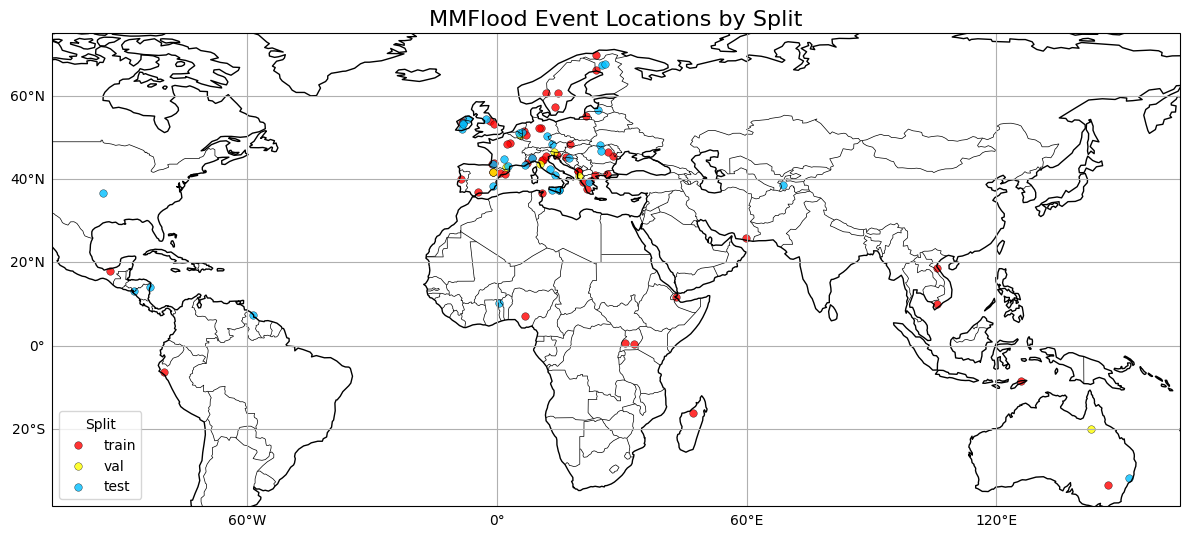

In [11]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

json_path = "/mnt/cephfs-mount/chenchen/mmflood/activations.json"


with open(json_path, "r") as f:
    data = json.load(f)

rows = []
for emsr_id, info in data.items():
    rows.append({
        "id": emsr_id,
        "title": info.get("title", ""),
        "country": info.get("country", ""),
        "lat": info["lat"],
        "lon": info["lon"],
        "subset": info["subset"],   # train / val / test
    })

df = pd.DataFrame(rows)
print(df.head())
print(df["subset"].value_counts())


fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_title("MMFlood Event Locations by Split", fontsize=16)


ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False


color_map = {
    "train": "red",         
    "val": "yellow",         
    "test": "deepskyblue",  
}

for split in ["train", "val", "test"]:
    sub = df[df["subset"] == split]
    if sub.empty:
        continue
    ax.scatter(
        sub["lon"],
        sub["lat"],
        s=30,
        marker="o",
        transform=ccrs.PlateCarree(),
        label=split,
        alpha=0.8,
        edgecolors="k",
        linewidths=0.3,
        c=color_map.get(split, "grey"),
    )

ax.legend(title="Split", loc="lower left")
plt.tight_layout()
plt.show()


In [9]:
from pathlib import Path
import rasterio
import pandas as pd

root = Path("/mnt/cephfs-mount/chenchen/mmflood")

records = []

for event_dir in root.iterdir():
    if not event_dir.is_dir():
        continue

    s1_dir = event_dir / "s1_raw"
    mask_dir = event_dir / "mask"
    if not s1_dir.exists() or not mask_dir.exists():
        continue

    for s1_path in s1_dir.glob("*.tif"):
        fname = s1_path.name
        m_path = mask_dir / fname
        if not m_path.exists():
            continue

        with rasterio.open(s1_path) as s1_src, rasterio.open(m_path) as m_src:
            s1_bands = s1_src.count
            s1_h, s1_w = s1_src.height, s1_src.width
            s1_dtype = s1_src.dtypes[0]      
            s1_crs = s1_src.crs.to_string() if s1_src.crs else None
            s1_res_x, s1_res_y = s1_src.res

            m_bands = m_src.count
            m_h, m_w = m_src.height, m_src.width
            m_dtype = m_src.dtypes[0]

        records.append({
            "event": event_dir.name,
            "file": fname,
            "s1_bands": s1_bands,
            "s1_height": s1_h,
            "s1_width": s1_w,
            "s1_dtype": s1_dtype,
            "s1_crs": s1_crs,
            "s1_res_x": s1_res_x,
            "s1_res_y": s1_res_y,
            "mask_bands": m_bands,
            "mask_height": m_h,
            "mask_width": m_w,
            "mask_dtype": m_dtype,
        })

df = pd.DataFrame(records)
df.head()


,event,file,s1_bands,s1_height,s1_width,s1_dtype,s1_crs,s1_res_x,s1_res_y,mask_bands,mask_height,mask_width,mask_dtype
0,EMSR332-6,EMSR332-6-17.tif,2,1280,557,float32,EPSG:4326,0.000128,0.00009,1,1280,557,float32
1,EMSR332-6,EMSR332-6-16.tif,2,1213,1288,float32,EPSG:4326,0.000128,0.00009,1,1213,1288,float32
2,EMSR332-6,EMSR332-6-9.tif,2,1312,1318,float32,EPSG:4326,0.000128,0.00009,1,1312,1318,float32
3,EMSR332-6,EMSR332-6-0.tif,2,710,695,float32,EPSG:4326,0.000128,0.00009,1,710,695,float32
4,EMSR332-6,EMSR332-6-6.tif,2,490,1359,float32,EPSG:4326,0.000128,0.00009,1,490,1359,float32


In [10]:
import rasterio
import numpy as np
from pathlib import Path

sample_mask = "/mnt/cephfs-mount/chenchen/mmflood/EMSR332-6/mask/EMSR332-6-17.tif"

with rasterio.open(sample_mask) as src:
    m = src.read(1)
    print("min:", np.nanmin(m), "max:", np.nanmax(m), "unique:", np.unique(m)[:10])


min: 0.0 max: 1.0 unique: [0. 1.]


333 EMSR...
 3 data...


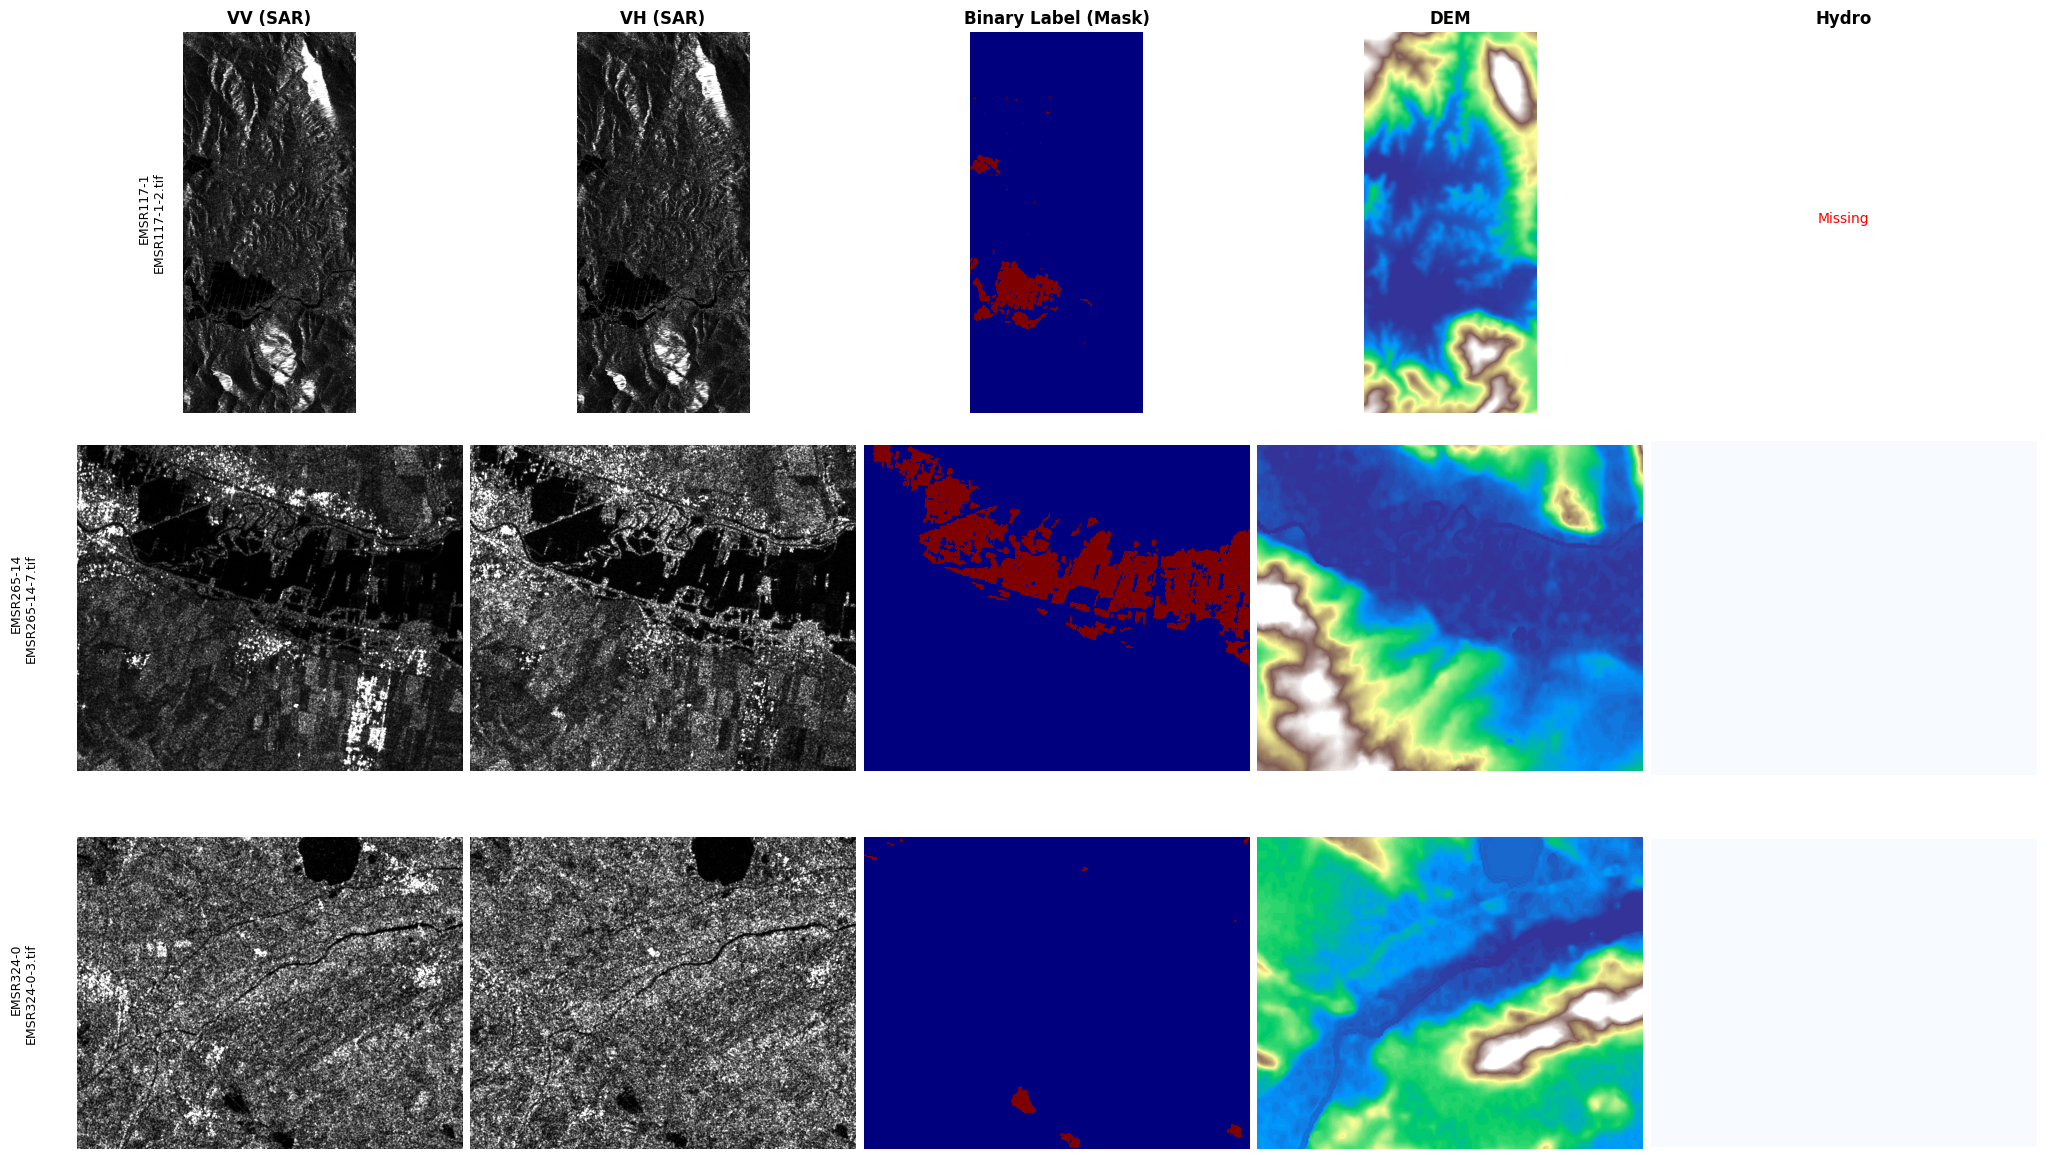

In [7]:
import os
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff


ROOT_DIR = "/mnt/cephfs-mount/chenchen/mmflood" 
ACTIVATIONS_DIR = os.path.join(ROOT_DIR)


def read_tif(path, band_index=None):
    if not os.path.exists(path):
        return None
    try:
        img = tiff.imread(path)
        if band_index is not None and img.ndim == 3:
            if img.shape[0] < img.shape[2]: # (C, H, W)
                return img[band_index, :, :]
            else: # (H, W, C)
                return img[:, :, band_index]
        return img
    except Exception as e:
        print(f"failed {path}: {e}")
        return None

def normalize_sar(img):
    if img is None: return None
    # 1. Log transform
    img_log = np.log1p(img)
    # 2. Percentile clipping
    vmin, vmax = np.percentile(img_log, [2, 98])
    return np.clip((img_log - vmin) / (vmax - vmin + 1e-6), 0, 1)


all_events = [d for d in os.listdir(ACTIVATIONS_DIR) if os.path.isdir(os.path.join(ACTIVATIONS_DIR, d))]
print(f"{len(all_events)} EMSR...")

if not all_events:
    print("failed")
    exit()

NUM_SAMPLES = 3
samples_to_plot = []

print(f" {NUM_SAMPLES} data...")

for _ in range(NUM_SAMPLES * 5): 
    if len(samples_to_plot) >= NUM_SAMPLES:
        break
        
    event_name = random.choice(all_events)
    event_dir = os.path.join(ACTIVATIONS_DIR, event_name)
  
    mask_dir = os.path.join(event_dir, "mask")
    if not os.path.exists(mask_dir): continue
    
    files = glob.glob(os.path.join(mask_dir, "*.tif"))
    if not files: continue

    selected_file = random.choice(files)
    filename = os.path.basename(selected_file)

    if any(s['filename'] == filename for s in samples_to_plot):
        continue
        
    samples_to_plot.append({
        "event": event_name,
        "filename": filename,
        "base_dir": event_dir
    })

if not samples_to_plot:
    print("failed")
    exit()

# VV, VH, Mask, DEM, Hydro
cols = ["VV (SAR)", "VH (SAR)", "Binary Label (Mask)", "DEM", "Hydro"]
fig, axes = plt.subplots(len(samples_to_plot), 5, figsize=(20, 4 * len(samples_to_plot)))


if len(samples_to_plot) == 1: axes = np.expand_dims(axes, axis=0)

for i, sample in enumerate(samples_to_plot):
    event_dir = sample['base_dir']
    fname = sample['filename']

    p_s1 = os.path.join(event_dir, "s1_raw", fname)
    p_mask = os.path.join(event_dir, "mask", fname)
    p_dem = os.path.join(event_dir, "DEM", fname) 
    p_hydro = os.path.join(event_dir, "hydro", fname)

    # s1_raw  0=VV, 1=VH
    img_s1_vv = read_tif(p_s1, band_index=0)
    img_s1_vh = read_tif(p_s1, band_index=1)
    img_mask = read_tif(p_mask)
    img_dem = read_tif(p_dem)
    img_hydro = read_tif(p_hydro)
    
    row_data = [
        (img_s1_vv, 'gray', True),   # VV, is_sar=True
        (img_s1_vh, 'gray', True),   # VH, is_sar=True
        (img_mask, 'jet', False),    # Mask
        (img_dem, 'terrain', False), # DEM
        (img_hydro, 'Blues', False)  # Hydro
    ]
    
    for j, (img, cmap, is_sar) in enumerate(row_data):
        ax = axes[i, j]
        
        if img is not None:
            if is_sar:
                display_img = normalize_sar(img)
                ax.imshow(display_img, cmap=cmap)
            elif cmap == 'jet': # Mask
                ax.imshow(img, cmap=cmap, interpolation='nearest')
            else:
                vmin, vmax = np.percentile(img, [2, 98]) if img.max() > img.min() else (None, None)
                ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            ax.text(0.5, 0.5, "Missing", ha='center', color='red')
            if j == 3: ax.set_title("DEM missing")
            
        ax.axis('off')

        if i == 0:
            ax.set_title(cols[j], fontsize=12, fontweight='bold')

    axes[i, 0].text(-0.1, 0.5, f"{sample['event']}\n{fname}", 
                    transform=axes[i, 0].transAxes, va='center', ha='right', fontsize=9, rotation=90)

plt.subplots_adjust(
    left=0.01, right=0.99, top=0.98, bottom=0.02,
    hspace=0.01, wspace=0.02
)



In [10]:
import os
import random 
from pathlib import Path

import rasterio
import numpy as np

ROOT = Path("/mnt/cephfs-mount/chenchen/mmflood_processed_github")
splits = ["train", "val", "test"]
modalities = ["sar", "dem", "mask", "images"] 

def list_stems(dir_path):
    if not dir_path.exists():
        return set()
    return {p.name for p in dir_path.glob("*.tif")}

for split in splits:
    print(f"\n===== Checking split: {split} =====")
    split_root = ROOT / split

    stems_per_mod = {}
    for mod in modalities:
        mod_dir = split_root / mod
        if mod_dir.exists():
            stems_per_mod[mod] = list_stems(mod_dir)
            print(f"{mod}: {len(stems_per_mod[mod])} files")
        else:
            print(f"{mod}: (not found)")

    mods = list(stems_per_mod.keys())
    base_mod = mods[0]
    base_set = stems_per_mod[base_mod]
    for mod in mods[1:]:
        diff1 = base_set - stems_per_mod[mod]
        diff2 = stems_per_mod[mod] - base_set
        print(f"\nCompare {base_mod} vs {mod}:")
        print(f"  {base_mod} only: {len(diff1)}")
        print(f"  {mod} only: {len(diff2)}")
        if len(diff1) > 0:
            print("  Example only-in-base:", list(diff1)[:5])
        if len(diff2) > 0:
            print("  Example only-in-mod :", list(diff2)[:5])

    if base_set:
        print("\nRandom sample check:")
        sample_files = random.sample(list(base_set), min(5, len(base_set)))
        for fname in sample_files:
            print(f"\n--- {fname} ---")
            for mod in mods:
                fpath = split_root / mod / fname
                with rasterio.open(fpath) as src:
                    arr = src.read()
                    print(
                        f"{mod}: shape={arr.shape}, dtype={arr.dtype}, "
                        f"min={arr.min()}, max={arr.max()}"
                    )
                    if mod == "mask":
                        uniq = np.unique(arr)
                        print(f"  unique values in mask: {uniq}")



===== Checking split: train =====
sar: 6181 files
dem: 6181 files
mask: 6181 files
images: 6181 files

Compare sar vs dem:
  sar only: 0
  dem only: 0

Compare sar vs mask:
  sar only: 0
  mask only: 0

Compare sar vs images:
  sar only: 0
  images only: 0

Random sample check:

--- EMSR192-2-1_0_38.tif ---
sar: shape=(2, 512, 512), dtype=float32, min=0.0004239087284076959, max=2.469886302947998
dem: shape=(1, 512, 512), dtype=float32, min=92.0, max=139.0
mask: shape=(1, 512, 512), dtype=float32, min=0.0, max=1.0
  unique values in mask: [0. 1.]
images: shape=(2, 512, 512), dtype=float32, min=0.0004239087284076959, max=2.469886302947998

--- EMSR424-4-9_453_172.tif ---
sar: shape=(2, 512, 512), dtype=float32, min=0.0004239087284076959, max=1.4017037153244019
dem: shape=(1, 512, 512), dtype=float32, min=751.0, max=962.0
mask: shape=(1, 512, 512), dtype=float32, min=0.0, max=1.0
  unique values in mask: [0. 1.]
images: shape=(2, 512, 512), dtype=float32, min=0.0004239087284076959, max=1